In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

import tensorflow as tf

_ = torch.manual_seed(42)

2022-12-23 11:04:56.842001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 11:04:58.015457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-23 11:04:58.015515: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-23 11:04:58.015523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Create useful directories
We will first create all useful directories used to store figures, datas and models

In [2]:
!mkdir -p ../data
!mkdir -p ../figures
!mkdir -p ../models

# Helper functions

Here are the implementation of some usefull functions

In [3]:
def saveModel(model, model_name, date=True):    
    if date: filename = f'../models/{model_name}_{datetime.now().strftime("%Y_%m_%d__%H_%M")})'
    else: filename = f'../models/{model_name}'
    
    torch.save(model.state_dict(), filename)

In [4]:
def loadModel(model, model_name):
    model.load_state_dict(torch.load(f'../models/{model_name}'))
    model.eval()
    return model

In [161]:
def showimgpanel(imgs, n_imgs, panelshape, figsize=None, 
                 labels=None, labels_prefix="Label : ",
                 title="", fontsize_title=30, fontsize_label=15, 
                 filename=None):
    x,y = panelshape
    if figsize is None: figsize = (3*y, 3*x)
    n_imgs = min(len(imgs), n_imgs, x*y)
    
    fig = plt.figure(figsize = figsize)
    fig.suptitle(title, fontsize = fontsize_title)
    fig.subplots_adjust(wspace=0.1, hspace=0.2)
    
    for i in range(n_imgs):
        ax = fig.add_subplot(x, y, i+1)
        img = imgs[i]
        
        if labels is None: label = ''
        else: label = labels_prefix + str(int(labels[i]))
        
        showimg(img, ax, title=label, fontsize=fontsize_label, savefig=False)            
        
    if filename is not None: plt.savefig(f"{filename}.png")
    

In [6]:
# Divide dataset into batches

def divideInBatches(dataset, batch_size):
    # Train set
    n_batches = np.ceil(len(dataset)/batch_size)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader, n_batches,

In [7]:
# Check if GPU is available

def chooseDevice():
    device = ""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU available")
    return device

In [97]:
def showimg(img, ax=None, shape=(28, 28), cmap='gray', title="", fontsize=15, axis=False, savefig=True, savedir=None):
    if ax is None: _, ax = plt.subplots()
    if not axis: ax.axis('off')
        
    img = img.reshape(shape)
    ax.imshow(img, cmap=cmap)
    ax.set_title(title, fontsize=fontsize)
    
    if savefig and savedir is not None: plt.savefig(f"{filename}{savedir}.png")

In [9]:
device = chooseDevice()

GPU available via cuda


# Define datasets
We first download the fashionMNIST dataset using the dataset module of the pytorch library.
Then we reduce the model to 20% of its original size to have a lowerbound for our data augmentation performances.

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

test_set = torchvision.datasets.FashionMNIST(root="../data/", train=False, download=True, transform=transform)
test_set_size = len(test_set)

full_train_set = torchvision.datasets.FashionMNIST(root="../data/", train=True, download=True, transform=transform)
full_train_set_size = len(full_train_set)

In [11]:
reduction_factor = 0.05

idxs = np.random.choice(np.arange(full_train_set_size), int(full_train_set_size*reduction_factor) ,replace=False)

# Normalize the data from [-1. to 1.]
reduced_data  = full_train_set.data[idxs].float()
reduced_data /= reduced_data.max() - reduced_data.min()
reduced_data  = 2. * reduced_data - 1.

reduced_labels = full_train_set.targets[idxs]

In [12]:
reduced_train_set = torch.utils.data.TensorDataset(reduced_data, reduced_labels)
reduced_train_set_size = len(reduced_data)

In [13]:
# Delete some, now, useless variables
del reduction_factor, idxs

In [14]:
batch_size = 32
n_classes = len(full_train_set.classes)

In [15]:
# Create base loader
full_train_loader,    full_train_n_batches    = divideInBatches(full_train_set, batch_size)
reduced_train_loader, reduced_train_n_batches = divideInBatches(reduced_train_set, batch_size)
test_loader,          test_n_batches          = divideInBatches(test_set, batch_size)

# Model definition
Here we will define the architecture of our models

## CNN model

In [16]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Sequential(             # Images input is batch_size*1*28*28
            nn.Conv2d(1, 16, 5, 1, 2),          # Output is batch_size*16*28*28
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),        # Output is batch_size*16*14*14
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),         # Output is batch_size*32*14*14
            nn.ReLU(),                      
            nn.MaxPool2d(2),                    # Output is batch_size*32*7*7
        )
        # fully connected layer, output one number for each class
        self.out = nn.Sequential(         
            nn.Linear(32 * 7 * 7, self.n_classes),          # Output is batch_size*n_classes
        )
    
    def scaleToProbabilities(self, outmap, scale_factor = 3): 
        # scale_factor allows to scale your output before passing it into the softmax function 
        # in order to get numbers interpratble as probabilities
        
        flattened_outmap = outmap.view(outmap.shape[0], -1)
        outmap_std = torch.std(flattened_outmap, dim = 1).view(-1, 1)
        outmap_scaled_std = torch.div(outmap, outmap_std)
        probabilities = nn.functional.softmax(outmap_scaled_std*scale_factor, dim=1)
        return probabilities
    
    def predictLabels(self, outmap, scale_factor = 3):
        probabilities = self.scaleToProbabilities(outmap, scale_factor = 3)
        certainty, predicted_labels = torch.max(probabilities, 1)
        predicted_labels = predicted_labels.data.squeeze()
        certainty = certainty.data.squeeze()
        return predicted_labels, probabilities, certainty
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), 32 * 7 * 7)
        output = self.out(x)
        return output

## Generator model

In [17]:
class Generator(nn.Module):

    def __init__(self, dim_latent_space):
        super().__init__()
        self.dim_latent_space = dim_latent_space
        self.fc = nn.Linear(self.dim_latent_space, 64*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.trans_conv2 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.trans_conv3 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.trans_conv4 = nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
    def forward(self, x):                   # Input = batch_size*dim_latent_space
        x = self.fc(x)                      # Output = batch_size*(64*7*7)
        x = x.view(-1, 64, 7, 7)            # Output = batch_size*64*7*7
        x = self.trans_conv1(x)             # Output = batch_size*64*14*14
        x = F.relu(self.batch_norm1(x))
        x = self.trans_conv2(x)             # Output = batch_size*32*14*14
        x = F.relu(self.batch_norm2(x))
        x = self.trans_conv3(x)             # Output = batch_size*16*14*14
        x = F.relu(self.batch_norm3(x))     
        x = self.trans_conv4(x)             # Output = batch_size*1*28*28
        x = torch.tanh(x)
        return x

# Training of the CNN

In [18]:
n_epoch_cnn = 20

In [19]:
def computeCNNAccuracy(y_predicted,y_true):
    accuracy = 0.0
    accuracy = torch.sum(y_predicted == y_true).item()/y_true.shape[0]
    return accuracy

In [20]:
def evaluate_raw_performances(cnn, train_loader, test_loader, train_n_batches, test_n_batches,
                              losses_train, accuracies_train, accuracies_test, 
                              loss_function, optimizer):
    cnn.eval()
    for batch_id, (data, labels) in enumerate(train_loader):
        data = data.reshape((-1,1,28,28))
        data = data.to(device)
        labels = labels.to(device)

        pred = cnn(data)

        labels_pred, labels_prob, _ = cnn.predictLabels(pred)

        target_prob = torch.zeros_like(labels_prob)
        for i,j in enumerate(labels):
            target_prob[i][j] = 1
        target_prob = target_prob.to(device)

        loss = loss_function(labels_prob, target_prob)
        
        optimizer.zero_grad()
        
        losses_train[0] += loss.item()
        accuracies_train[0] += computeCNNAccuracy(labels_pred, labels)

    accuracies_train[0] /= train_n_batches
    losses_train[0] /= train_n_batches

    cnn.eval()
    for batch_id, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        labels = labels.to(device)
        pred = cnn(data)

        labels_pred, _, _ = cnn.predictLabels(pred)

        accuracies_test[0] += computeCNNAccuracy(labels_pred, labels)

    accuracies_test[0] /= test_n_batches

    print(f"Accuracy during training: {accuracies_train[0]*100:.2f}%")
    print(f"Accuracy during test:     {accuracies_test[0]*100:.2f}%")
    print(f"Loss during training:     {losses_train[0]:.2f}")

In [21]:
def train_cnn(cnn, train_loader, test_loader, train_n_batches, test_n_batches,
              losses_train, accuracies_train, accuracies_test, 
              loss_function, optimizer, n_epoch):
    # Training of the CNN
    for epoch in range(n_epoch):
        cnn.train()
        for batch_id, (data, labels) in enumerate(train_loader):
            data = data.reshape((-1,1,28,28))
            data = data.to(device)
            labels = labels.to(device)

            pred = cnn(data)

            labels_pred, labels_prob, _ = cnn.predictLabels(pred)

            target_prob = torch.zeros_like(labels_prob)
            for i,j in enumerate(labels):
                target_prob[i][j] = 1
            target_prob = target_prob.to(device)

            loss = loss_function(labels_prob, target_prob)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses_train[epoch + 1] += loss.item()
            accuracies_train[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

        accuracies_train[epoch + 1] /= train_n_batches
        losses_train[epoch + 1] /= train_n_batches

        cnn.eval()
        for batch_id, (real, labels) in enumerate(test_loader):
            real = real.to(device)
            labels = labels.to(device)
            pred = cnn(real)

            labels_pred, _, _ = cnn.predictLabels(pred)

            accuracies_test[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

        accuracies_test[epoch + 1] /= test_n_batches

        print(f"Epoch [{epoch + 1:2d}/{n_epoch:2d}] \
                Accuracy: {accuracies_test[epoch + 1]:.4f} \
                Loss:     {losses_train[epoch + 1]:.4f}")

## Train CNN on full data set

In [22]:
cnn_full = CNN(n_classes).to(device=device)

In [23]:
# Loss function for the CNN
loss_function_cnn_full = nn.CrossEntropyLoss()

In [24]:
# Adam optimization parameters
lr_cnn_full = 0.001
betas_cnn_full = (0.9, 0.999)

optimizer_cnn_full = torch.optim.Adam(cnn_full.parameters(), lr=lr_cnn_full, betas = betas_cnn_full)

In [25]:
%%time

# Error metrics at initialisation

losses_train_cnn_full     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn_full = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn_full  = np.zeros(n_epoch_cnn+1)

evaluate_raw_performances(cnn_full, full_train_loader, test_loader, full_train_n_batches, test_n_batches,
                          losses_train_cnn_full, accuracies_train_cnn_full, accuracies_test_cnn_full, 
                          loss_function_cnn_full, optimizer_cnn_full)
print()

Accuracy during training: 4.88%
Accuracy during test:     4.88%
Loss during training:     2.35

CPU times: user 13.9 s, sys: 466 ms, total: 14.4 s
Wall time: 15 s


In [26]:
%%time
train_cnn(cnn_full, full_train_loader, test_loader, full_train_n_batches, test_n_batches,
          losses_train_cnn_full, accuracies_train_cnn_full, accuracies_test_cnn_full, 
          loss_function_cnn_full, optimizer_cnn_full,n_epoch_cnn)

print()
torch.cuda.empty_cache() 

Epoch [ 1/20]                 Accuracy: 0.8717                 Loss:     1.6308
Epoch [ 2/20]                 Accuracy: 0.8888                 Loss:     1.5777
Epoch [ 3/20]                 Accuracy: 0.8884                 Loss:     1.5654
Epoch [ 4/20]                 Accuracy: 0.9020                 Loss:     1.5579
Epoch [ 5/20]                 Accuracy: 0.9011                 Loss:     1.5514
Epoch [ 6/20]                 Accuracy: 0.9060                 Loss:     1.5472
Epoch [ 7/20]                 Accuracy: 0.9052                 Loss:     1.5423
Epoch [ 8/20]                 Accuracy: 0.9048                 Loss:     1.5385
Epoch [ 9/20]                 Accuracy: 0.9062                 Loss:     1.5357
Epoch [10/20]                 Accuracy: 0.9035                 Loss:     1.5325
Epoch [11/20]                 Accuracy: 0.9094                 Loss:     1.5302
Epoch [12/20]                 Accuracy: 0.9070                 Loss:     1.5277
Epoch [13/20]                 Accuracy: 

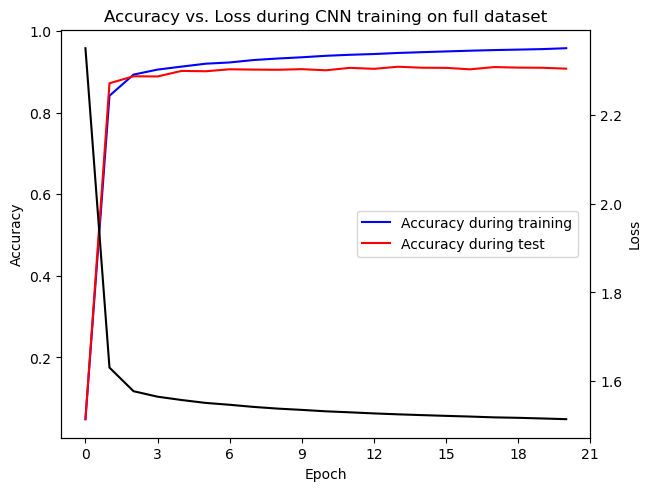

In [77]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)

fig, ax1 = plt.subplots(constrained_layout=True)
ax1.set_title('Accuracy vs. Loss during CNN training on full dataset')
ax1.set_xlabel('Epoch')


ax1.plot(epochs, accuracies_train_cnn_full, c='blue', label = "Accuracy during training")
ax1.plot(epochs, accuracies_test_cnn_full, c='red', label = "Accuracy during test")

ax2 = ax1.twinx()
ax2.plot(epochs, losses_train_cnn_full,c = 'black', label = "Loss during train")

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.legend(loc= 7, bbox_to_anchor=(.99,.5))

plt.savefig("../figures/CNN_metrics_full.png")

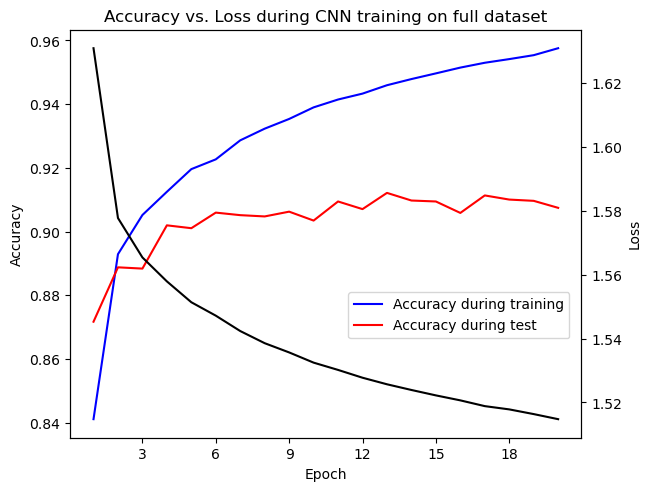

In [78]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)

fig, ax1 = plt.subplots(constrained_layout=True)
ax1.set_title('Accuracy vs. Loss during CNN training on full dataset')
ax1.set_xlabel('Epoch')


ax1.plot(epochs[1:], accuracies_train_cnn_full[1:], c='blue', label = "Accuracy during training")
ax1.plot(epochs[1:], accuracies_test_cnn_full[1:], c='red', label = "Accuracy during test")

ax2 = ax1.twinx()
ax2.plot(epochs[1:], losses_train_cnn_full[1:],c = 'black', label = "Loss during train")

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.legend(loc= 7, bbox_to_anchor=(.99,.3))

plt.savefig("../figures/CNN_metrics_full_cropped.png")

## Train CNN on reduced data set

In [82]:
cnn_reduced = CNN(n_classes).to(device=device)

In [83]:
# Loss function for the CNN
loss_function_cnn_reduced = nn.CrossEntropyLoss()

In [84]:
# Adam optimization parameters
lr_cnn_reduced = 0.001
betas_cnn_reduced = (0.9, 0.999)

optimizer_cnn_reduced = torch.optim.Adam(cnn_reduced.parameters(), lr=lr_cnn_reduced, betas = betas_cnn_reduced)

In [85]:
%%time

# Error metrics at initialisation

losses_train_cnn_reduced     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn_reduced = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn_reduced  = np.zeros(n_epoch_cnn+1)

evaluate_raw_performances(cnn_reduced, reduced_train_loader, test_loader, reduced_train_n_batches, test_n_batches,
                          losses_train_cnn_reduced, accuracies_train_cnn_reduced, accuracies_test_cnn_reduced, 
                          loss_function_cnn_reduced, optimizer_cnn_reduced)

print()

Accuracy during training: 18.07%
Accuracy during test:     18.49%
Loss during training:     2.28

CPU times: user 1.89 s, sys: 2.02 ms, total: 1.89 s
Wall time: 1.9 s


In [86]:
%%time
train_cnn(cnn_reduced, reduced_train_loader, test_loader, reduced_train_n_batches, test_n_batches,
          losses_train_cnn_reduced, accuracies_train_cnn_reduced, accuracies_test_cnn_reduced, 
          loss_function_cnn_reduced, optimizer_cnn_reduced,n_epoch_cnn)

print()
torch.cuda.empty_cache() 

Epoch [ 1/20]                 Accuracy: 0.7491                 Loss:     1.8838
Epoch [ 2/20]                 Accuracy: 0.7833                 Loss:     1.6946
Epoch [ 3/20]                 Accuracy: 0.8081                 Loss:     1.6429
Epoch [ 4/20]                 Accuracy: 0.8149                 Loss:     1.6081
Epoch [ 5/20]                 Accuracy: 0.8325                 Loss:     1.5917
Epoch [ 6/20]                 Accuracy: 0.8330                 Loss:     1.5760
Epoch [ 7/20]                 Accuracy: 0.8300                 Loss:     1.5621
Epoch [ 8/20]                 Accuracy: 0.8351                 Loss:     1.5581
Epoch [ 9/20]                 Accuracy: 0.8298                 Loss:     1.5513
Epoch [10/20]                 Accuracy: 0.8447                 Loss:     1.5412
Epoch [11/20]                 Accuracy: 0.8369                 Loss:     1.5315
Epoch [12/20]                 Accuracy: 0.8369                 Loss:     1.5286
Epoch [13/20]                 Accuracy: 

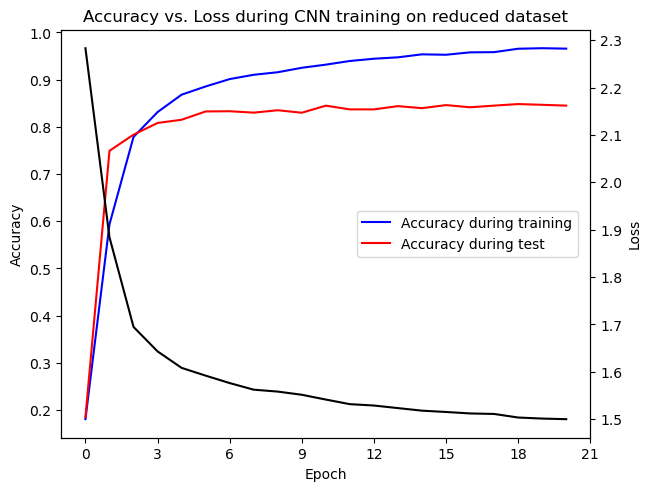

In [91]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)

fig, ax1 = plt.subplots(constrained_layout=True)
ax1.set_title('Accuracy vs. Loss during CNN training on reduced dataset')
ax1.set_xlabel('Epoch')


ax1.plot(epochs, accuracies_train_cnn_reduced, c='blue', label = "Accuracy during training")
ax1.plot(epochs, accuracies_test_cnn_reduced, c='red', label = "Accuracy during test")

ax2 = ax1.twinx()
ax2.plot(epochs, losses_train_cnn_reduced,c = 'black', label = "Loss during train")

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.legend(loc= 7, bbox_to_anchor=(.99,.5))

plt.savefig("../figures/CNN_metrics_reduced.png")

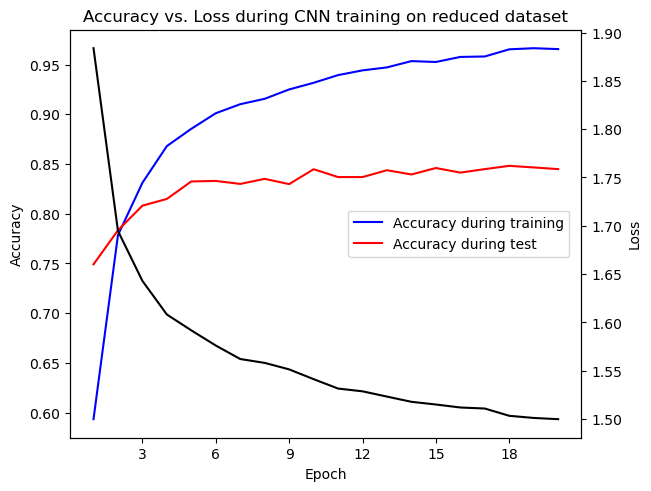

In [93]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)

fig, ax1 = plt.subplots(constrained_layout=True)
ax1.set_title('Accuracy vs. Loss during CNN training on reduced dataset')
ax1.set_xlabel('Epoch')

ax1.plot(epochs[1:], accuracies_train_cnn_reduced[1:], c='blue', label = "Accuracy during training")
ax1.plot(epochs[1:], accuracies_test_cnn_reduced[1:], c='red', label = "Accuracy during test")

ax2 = ax1.twinx()
ax2.plot(epochs[1:], losses_train_cnn_reduced[1:],c = 'black', label = "Loss during train")

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.legend(loc= 7, bbox_to_anchor=(.99,.5))

plt.savefig("../figures/CNN_metrics_reduced_cropped.png")

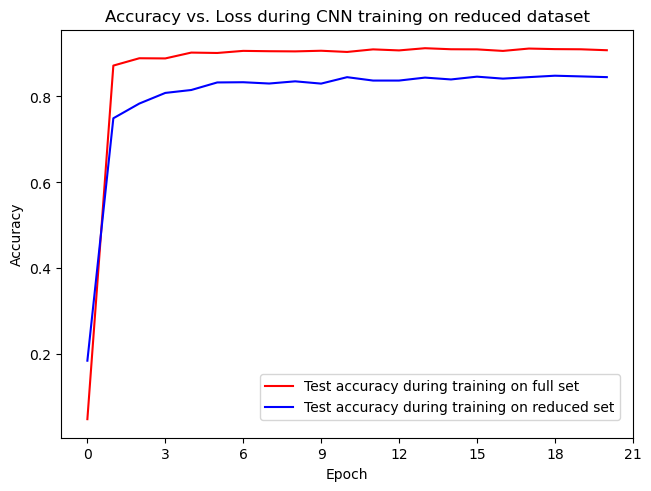

In [96]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Accuracy vs. Loss during CNN training on reduced dataset')
ax.set_xlabel('Epoch')

ax.plot(epochs, accuracies_test_cnn_full, c='red', label = "Test accuracy during training on full set")
ax.plot(epochs, accuracies_test_cnn_reduced, c='blue', label = "Test accuracy during training on reduced set")

ax.set_ylabel('Accuracy')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.legend(loc= 7, bbox_to_anchor=(.99,.1))

plt.savefig("../figures/CNN_metrics_bounds.png")

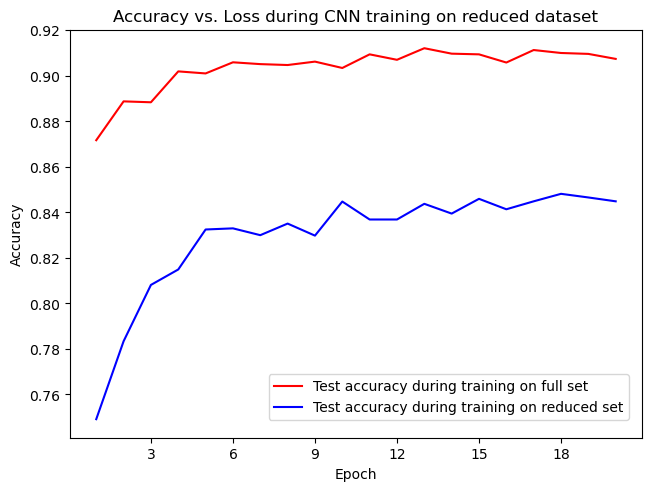

In [95]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Accuracy vs. Loss during CNN training on reduced dataset')
ax.set_xlabel('Epoch')

ax.plot(epochs[1:], accuracies_test_cnn_full[1:], c='red', label = "Test accuracy during training on full set")
ax.plot(epochs[1:], accuracies_test_cnn_reduced[1:], c='blue', label = "Test accuracy during training on reduced set")

ax.set_ylabel('Accuracy')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.legend(loc= 7, bbox_to_anchor=(.99,.1))

plt.savefig("../figures/CNN_metrics_bounds_cropped.png")

# Data augmentation
In this section we will explore mutliple data augmentation techniques and observe their effect on the CNN models

In [154]:
train_set_rotated = []
n_rot = 5
max_deg = 5
#make n_rot random rotation (±max_deg) on the reduced train set
for j in range(n_rot):
    train_set_rotated.append(tf.keras.preprocessing.image.random_rotation(reduced_data, max_deg, row_axis=1, col_axis=2, channel_axis=0)[:5])

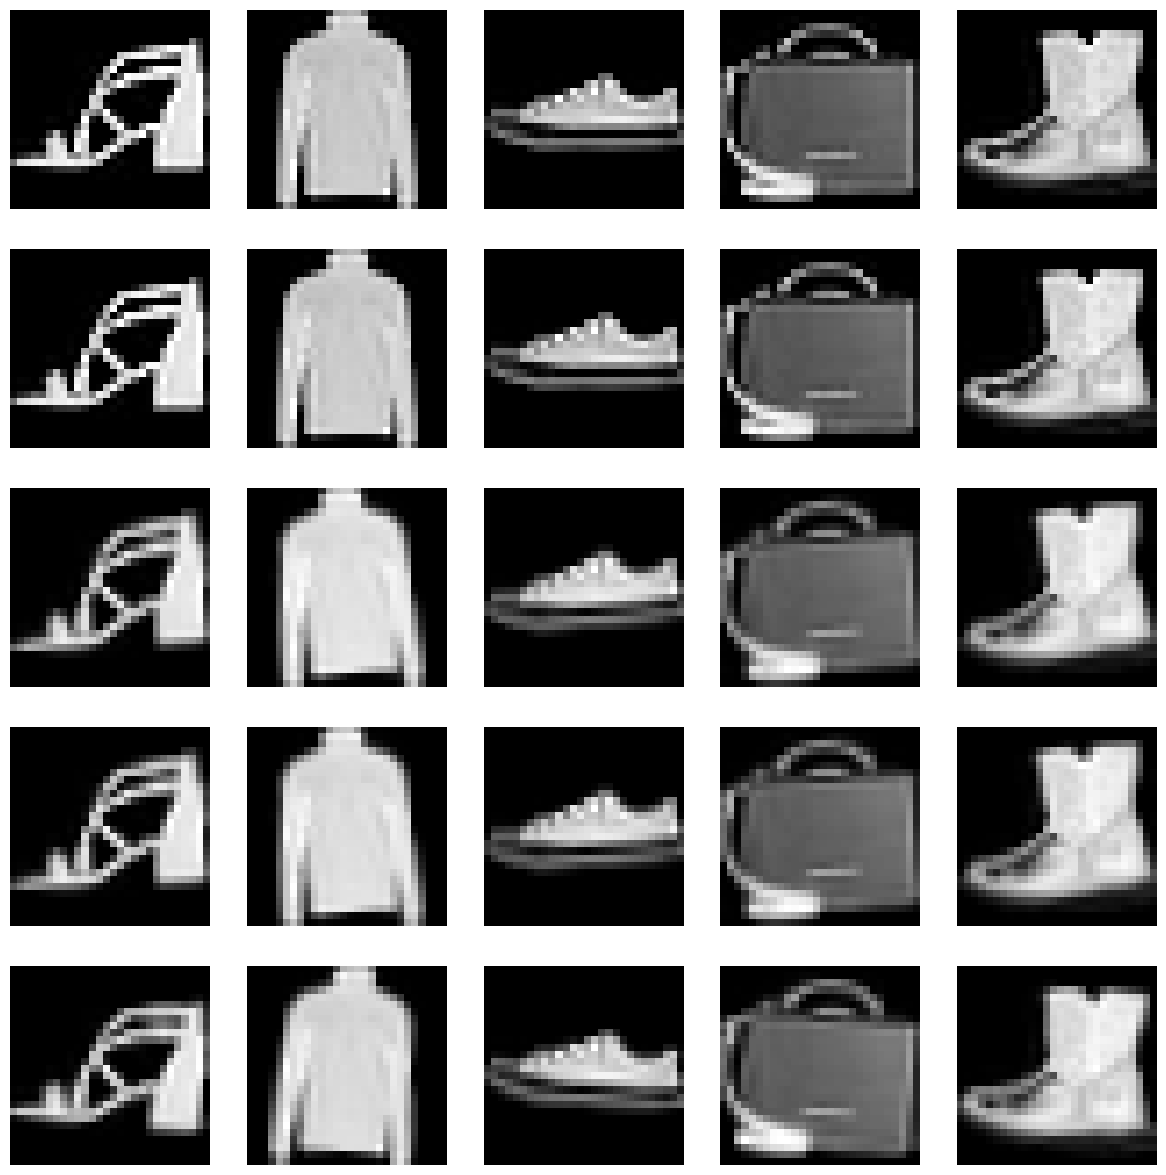

In [155]:
#show the first 20 original imgs and the 10 random rotation maked on it
data = np.vstack((reduced_data[:5], np.reshape(train_set_rotated,(-1,28,28))))

showimgpanel(data,25,(5,5), filename="../figures/rotation_example")

In [156]:
#flip image left to right on reduced train set
train_set_flip = []
for i in range(len(reduced_data)):
    train_set_flip.append(np.fliplr(reduced_data[i]))
train_set_flip = np.asarray(train_set_flip)

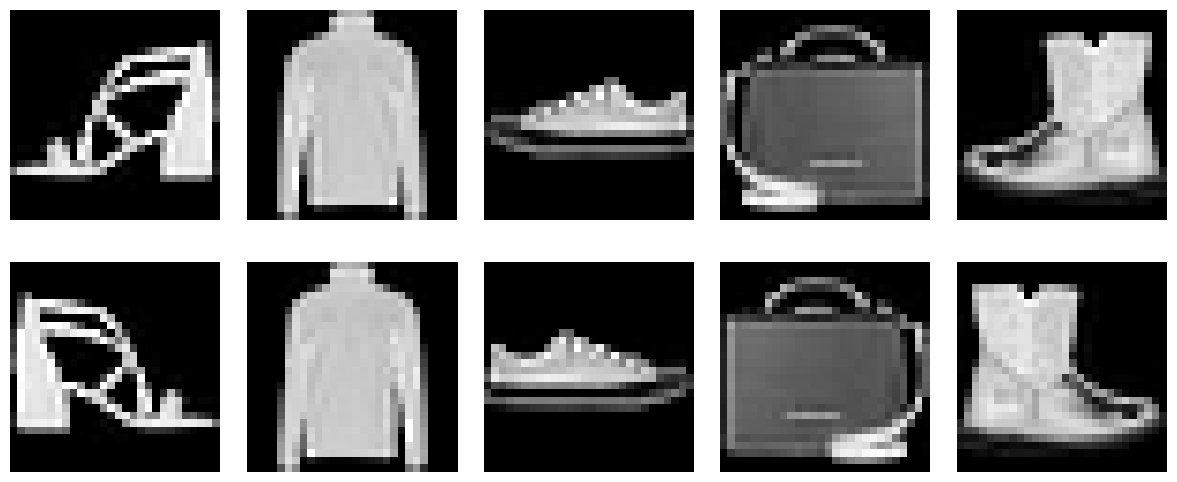

In [163]:
data = np.vstack((reduced_data[:5], train_set_flip))
showimgpanel(data,10,(2,5), filename="../figures/flip_example")

In [164]:
train_set_noisy = []
mean = 0
std = 0.1
n_noise = 5
#make 10 noisy version based on the original with differents std
for i in range(1,n_noise+1):
    noise = np.random.uniform(mean, i*std, reduced_data.shape)
    noise_image = reduced_data + noise
    train_set_noisy.append(noise_image)

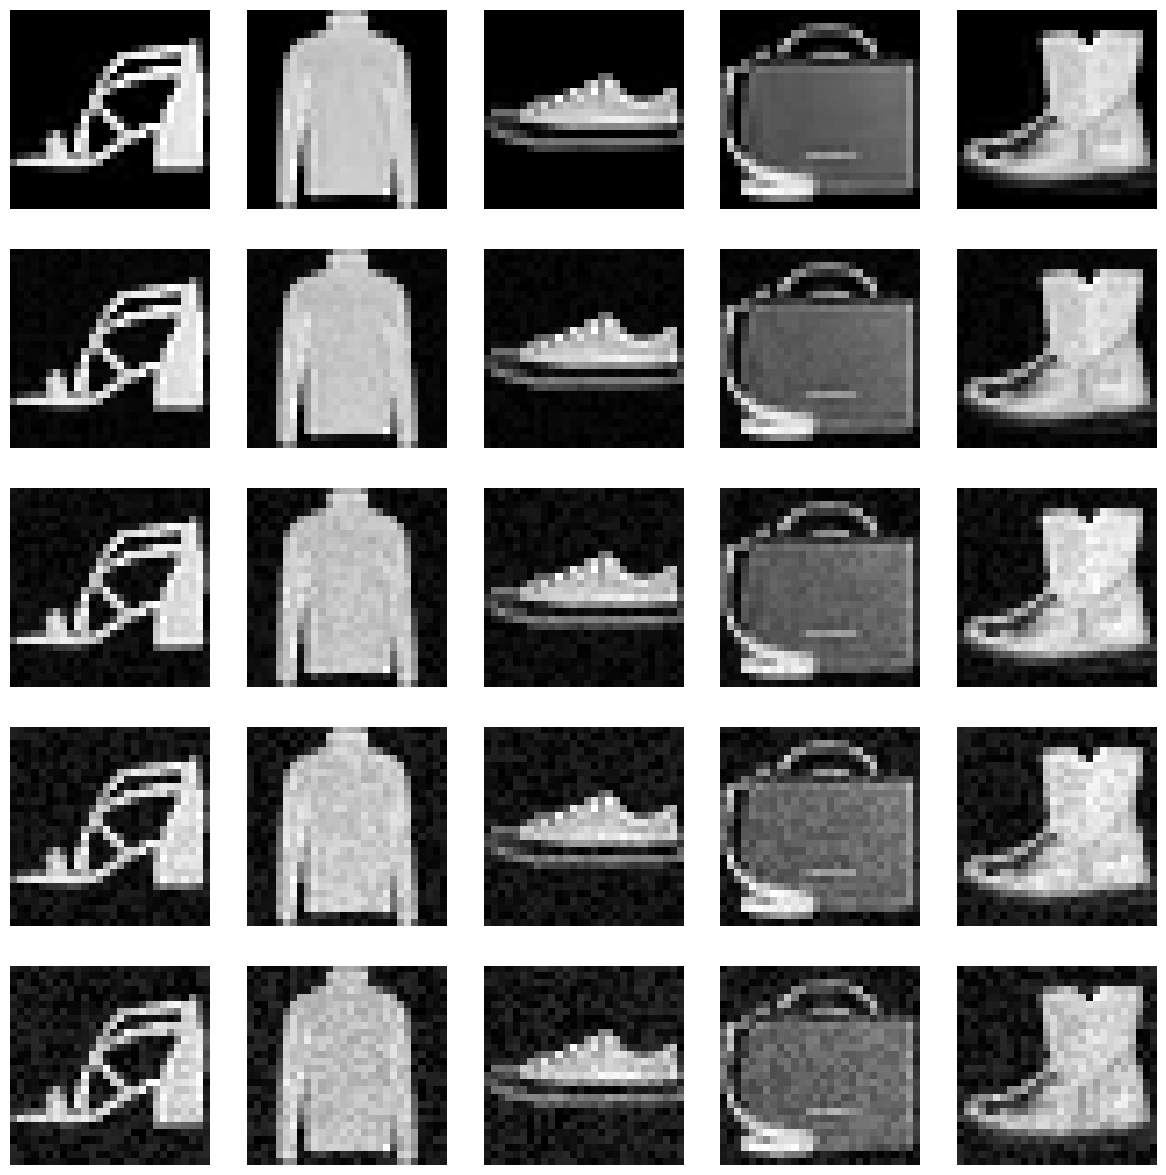

In [165]:
data = np.vstack([reduced_data[:5]]+[tensor.cpu().detach()[:5] for tensor in train_set_noisy])
showimgpanel(data,25,(5,5), filename="../figures/noise_example")

## Train CNN on augmented data

In [28]:
rot_data = torch.clone(reduced_data)
rot_labels = torch.clone(reduced_labels)

In [ ]:
#add original
rot_data = torch.vstack((rot_data, reduced_data))
rot_labels = torch.hstack((rot_labels, reduced_labels))

In [29]:
#add rotations
for i in range(n_rot):
    rot_data = torch.vstack((rot_data, torch.tensor(train_set_rotated[i])))
    rot_labels = torch.hstack((rot_labels, reduced_labels))

In [ ]:
#add flip
rot_data = torch.vstack((rot_data, torch.tensor(train_set_flip)))
rot_labels = torch.hstack((rot_labels, reduced_labels))

In [ ]:
#add noise
for i in range(n_noise):
    rot_data = torch.vstack((rot_data, train_set_noisy[i].float()))
    rot_labels = torch.hstack((rot_labels, reduced_labels))

In [30]:
rot_train_set = torch.utils.data.TensorDataset(rot_data, rot_labels)
rot_train_set_size = len(rot_data)

rot_train_loader, rot_train_n_batches = divideInBatches(rot_train_set, batch_size)

In [31]:
print(f"{rot_train_set_size} records. It corresponds to an augmentation of +{100.*(rot_train_set_size/reduced_train_set_size-1.):.2f}% in comparison to the initial reduced dataset.")

33000 records. It corresponds to an augmentation of +1000.00% in comparison to the initial reduced dataset.


In [32]:
cnn_rot = CNN(n_classes).to(device=device)

In [33]:
# Loss function for the CNN
loss_function_cnn_rot = nn.CrossEntropyLoss()

In [34]:
# Adam optimization parameters
lr_cnn_rot = 0.001
betas_cnn_rot = (0.9, 0.999)

optimizer_cnn_rot = torch.optim.Adam(cnn_rot.parameters(), lr=lr_cnn_rot, betas = betas_cnn_rot)

In [35]:
%%time

# Error metrics at initialisation

losses_train_cnn_rot     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn_rot = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn_rot  = np.zeros(n_epoch_cnn+1)

evaluate_raw_performances(cnn_rot, rot_train_loader, test_loader, rot_train_n_batches, test_n_batches,
                          losses_train_cnn_rot, accuracies_train_cnn_rot, accuracies_test_cnn_rot, 
                          loss_function_cnn_rot, optimizer_cnn_rot)

print()

Accuracy during training: 4.53%
Accuracy during test:     4.88%
Loss during training:     2.35

CPU times: user 15.3 s, sys: 39.3 ms, total: 15.4 s
Wall time: 8.49 s


In [36]:
%%time
train_cnn(cnn_rot, rot_train_loader, test_loader, rot_train_n_batches, test_n_batches,
          losses_train_cnn_rot, accuracies_train_cnn_rot, accuracies_test_cnn_rot, 
          loss_function_cnn_rot, optimizer_cnn_rot,n_epoch_cnn)

print()
torch.cuda.empty_cache() 

Epoch [ 1/ 5]                 Accuracy: 0.8418                 Loss:     1.6311
Epoch [ 2/ 5]                 Accuracy: 0.8598                 Loss:     1.5263
Epoch [ 3/ 5]                 Accuracy: 0.8548                 Loss:     1.5040
Epoch [ 4/ 5]                 Accuracy: 0.8502                 Loss:     1.4919
Epoch [ 5/ 5]                 Accuracy: 0.8561                 Loss:     1.4853

CPU times: user 2min 20s, sys: 260 ms, total: 2min 20s
Wall time: 1min 14s


NameError: name 'losses_train_cnn_full' is not defined

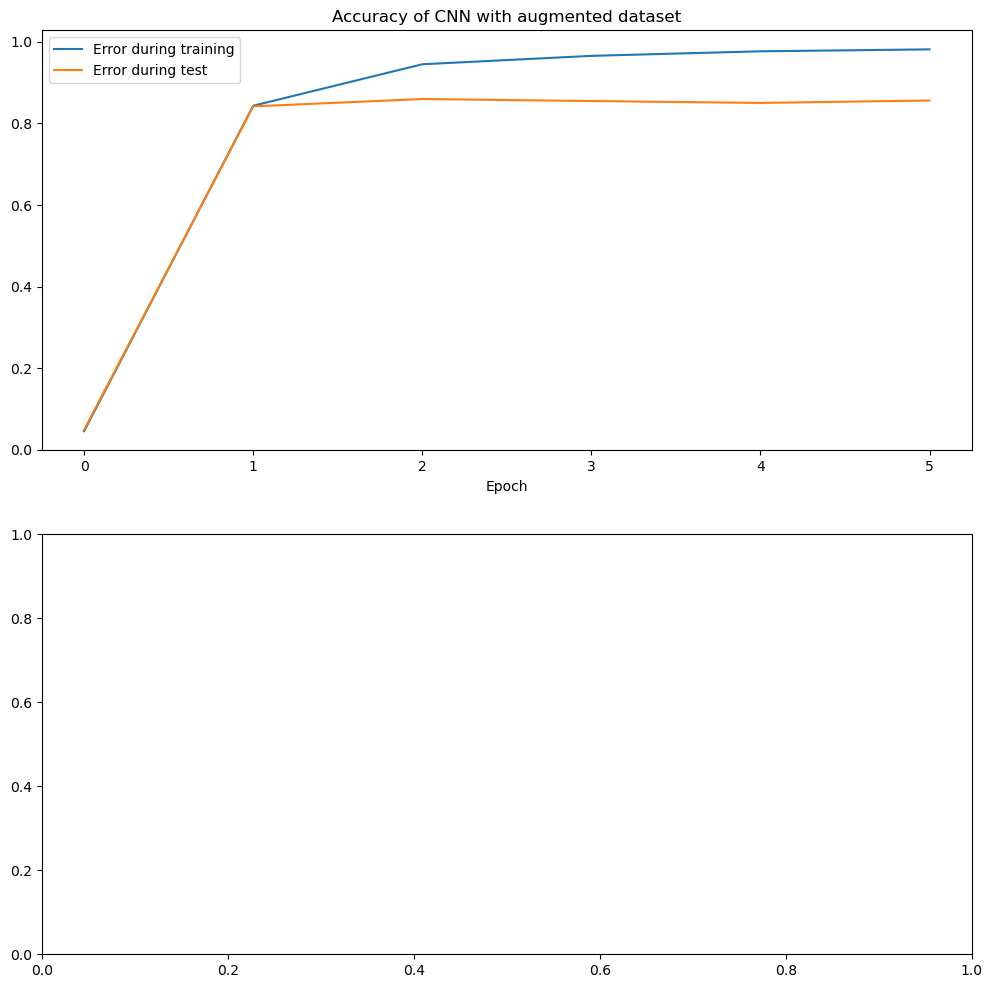

In [37]:
# Plots of accuracy and of loss function, augmented dataset.
epochs = np.arange(n_epoch_cnn+1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

ax1.plot(epochs, accuracies_train_cnn_rot, label = "Error during training")
ax1.plot(epochs, accuracies_test_cnn_rot, label = "Error during test")
ax1.set_title('Accuracy of CNN with augmented dataset')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(epochs, losses_train_cnn_full)
ax2.set_title('CNN loss with augmented dataset')
ax2.set_xlabel('Epoch')


for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.savefig("../figures/CNN_Metrics_aug.png")

NameError: name 'accuracies_test_cnn_reduced' is not defined

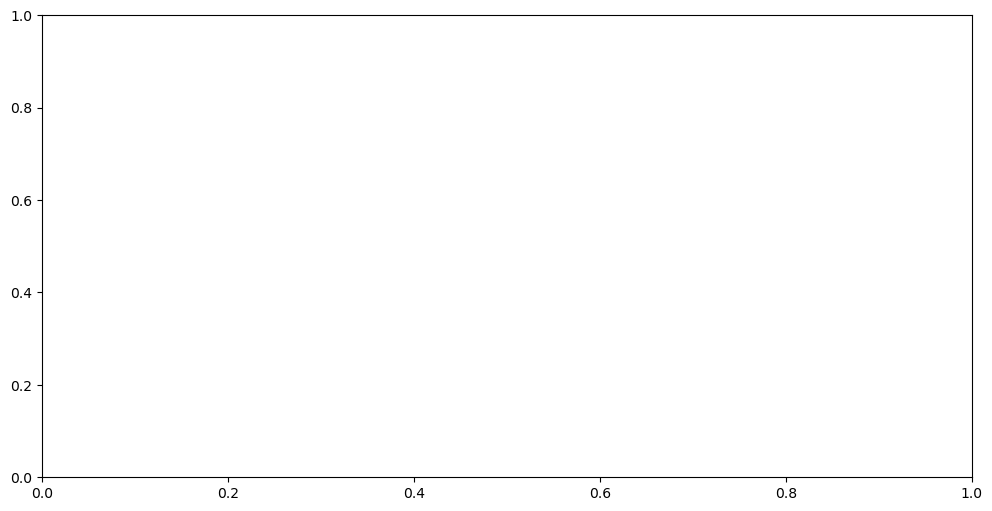

In [38]:
# Plots of accuracy and of loss function, comparaison reduced augmented
epochs = np.arange(n_epoch_cnn+1)
fig,  ax1= plt.subplots(1, 1, figsize=(12,6))

ax1.plot(epochs, accuracies_test_cnn_reduced, label = "Reduced dataset")
ax1.plot(epochs, accuracies_test_cnn_rot, label = "Augmented dataset")
ax1.set_title('Accuracy of CNN during test')
ax1.set_xlabel('Epoch')
ax1.legend()

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.savefig("../figures/CNN_Accuracy_comparison_aug.png")

## Synthetic Minority Over-sampling Technique (SMOTE)
SMOTE (Synthetic Minority Oversampling Technique) is a popular technique for oversampling in imbalanced data sets in machine learning. It is used to synthesize new minority class examples in order to increase the number of minority class instances and balance the class distribution.

The goal of SMOTE is to address the issue of imbalanced data sets, where one class (the minority class) is significantly underrepresented compared to the other class (the majority class). In such cases, machine learning algorithms can often have a biased learning towards the majority class, leading to poor performance on the minority class. By synthesizing new minority class examples, SMOTE helps to balance the class distribution and improve the performance of the model on the minority class.

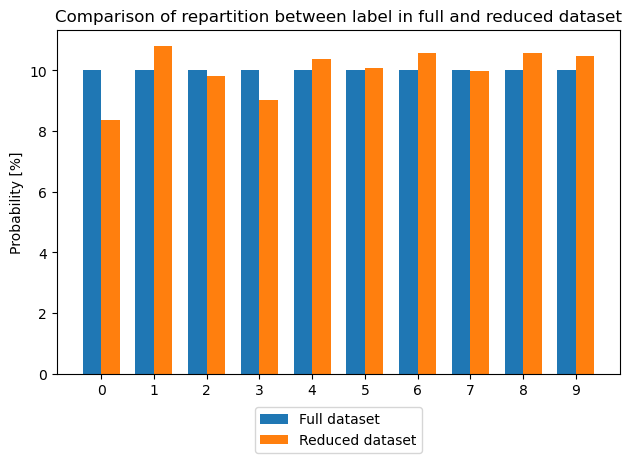

In [43]:
reduced_train_set.tensors[1]

n_full = np.zeros(n_classes)
n_reduced = np.zeros(n_classes)
for label in range(n_classes):
    n_full[label] = torch.sum((full_train_set.targets == label).int())
    n_reduced[label] = torch.sum((reduced_train_set.tensors[1] == label).int())

p_full = n_full/full_train_set_size
p_reduced = n_reduced/reduced_train_set_size

x = np.arange(n_classes)  # the label locations
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, p_full*100, width, label='Full dataset')
rects2 = ax.bar(x + width/2, p_reduced*100, width, label='Reduced dataset')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability [%]')
ax.set_title(f'Comparison of repartition between label in full and reduced dataset')
ax.set_xticks(x, x)
ax.legend(loc='lower center',bbox_to_anchor=(.5,-.25))

fig.tight_layout()

plt.savefig("../figures/labels_repartition_initial")
plt.show()


We can observe that the full fashion MNIST dataset is perfectly balanced. We are going to apply SMOTE methode to balance our reduced dataset.

In [54]:
smote_data = torch.clone(reduced_data)
smote_labels = torch.clone(reduced_labels)

In [55]:
n_max = int(np.max(n_reduced))

for label in range(n_classes):
    idxs = np.arange(reduced_train_set_size)[reduced_train_set.tensors[1]==label]
    
    n_missing = int(n_max-n_reduced[label])
    print(f"\nGenerating {n_missing:2d} images of label '{full_train_set.classes[label]}' with 10% of the set")
    for i in range(n_missing):
        idxs = np.random.choice(np.arange(n_classes), int(n_reduced[label]*0.1))
        smote_data = torch.vstack((smote_data, torch.mean(reduced_data[idxs], dim=0).reshape((1,28,28))))
        smote_labels = torch.hstack((smote_labels, torch.tensor([label])))


Generating 73 images of label 'T-shirt/top' with 10% of the set

Generating  0 images of label 'Trouser' with 10% of the set

Generating 30 images of label 'Pullover' with 10% of the set

Generating 53 images of label 'Dress' with 10% of the set

Generating 13 images of label 'Coat' with 10% of the set

Generating 22 images of label 'Sandal' with 10% of the set

Generating  7 images of label 'Shirt' with 10% of the set

Generating 25 images of label 'Sneaker' with 10% of the set

Generating  7 images of label 'Bag' with 10% of the set

Generating 10 images of label 'Ankle boot' with 10% of the set


In [56]:
smote_train_set = torch.utils.data.TensorDataset(smote_data, smote_labels)
smote_train_set_size = len(smote_data)

smote_train_loader, smote_train_n_batches = divideInBatches(smote_train_set, batch_size)

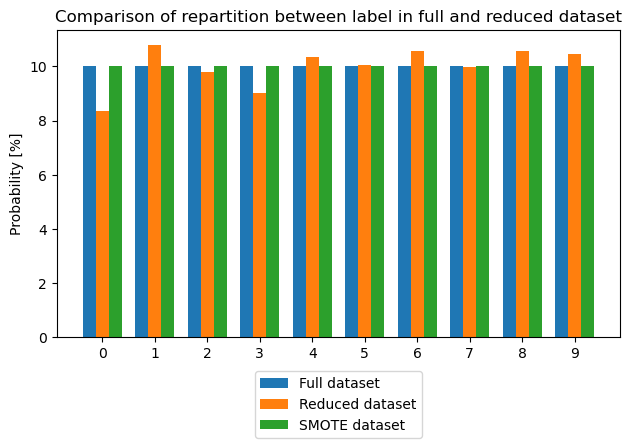

In [57]:
reduced_train_set.tensors[1]

n_smote = np.zeros(n_classes)
for label in range(n_classes):
    n_smote[label] = torch.sum((smote_labels == label).int())

p_smote = n_smote/smote_train_set_size

x = np.arange(n_classes)  # the label locations
width = 0.25       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, p_full*100, width, label='Full dataset')
rects2 = ax.bar(x , p_reduced*100, width, label='Reduced dataset')
rects3 = ax.bar(x + width, p_smote*100, width, label='SMOTE dataset')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability [%]')
ax.set_title(f'Comparison of repartition between label in full and reduced dataset')
ax.set_xticks(x, x)
ax.legend(loc='lower center',bbox_to_anchor=(.5,-.35))

fig.tight_layout()

plt.savefig("../figures/labels_repartition_smote")
plt.show()

The dataset obtained after SMOTE method is indeed balanced as we can see. This dataset does now contain:

In [58]:
print(f"{smote_train_set_size} records. It corresponds to an augmentation of +{100.*(smote_train_set_size/reduced_train_set_size-1.):.2f}% in comparison to the initial reduced dataset.")

3240 records. It corresponds to an augmentation of +8.00% in comparison to the initial reduced dataset.


In [59]:
cnn_smote = CNN(n_classes).to(device=device)
# Loss function for the CNN
loss_function_cnn_smote = nn.CrossEntropyLoss()
# Adam optimization parameters
lr_cnn_smote = 0.001
betas_cnn_smote = (0.9, 0.999)

optimizer_cnn_smote = torch.optim.Adam(cnn_smote.parameters(), lr=lr_cnn_smote, betas = betas_cnn_smote)

In [60]:
%%time

# Error metrics at initialisation

losses_train_cnn_smote     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn_smote = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn_smote  = np.zeros(n_epoch_cnn+1)

evaluate_raw_performances(cnn_smote, smote_train_loader, test_loader, smote_train_n_batches, test_n_batches,
                          losses_train_cnn_smote, accuracies_train_cnn_smote, accuracies_test_cnn_smote, 
                          loss_function_cnn_smote, optimizer_cnn_smote)

print()

Accuracy during training: 10.23%
Accuracy during test:     10.22%
Loss during training:     2.33

CPU times: user 1.91 s, sys: 5.77 ms, total: 1.92 s
Wall time: 1.93 s


In [61]:
%%time
train_cnn(cnn_smote, smote_train_loader, test_loader, smote_train_n_batches, test_n_batches,
          losses_train_cnn_smote, accuracies_train_cnn_smote, accuracies_test_cnn_smote, 
          loss_function_cnn_smote, optimizer_cnn_smote,n_epoch_cnn)

print()
torch.cuda.empty_cache() 

Epoch [ 1/20]                 Accuracy: 0.7628                 Loss:     1.8963
Epoch [ 2/20]                 Accuracy: 0.8144                 Loss:     1.7091
Epoch [ 3/20]                 Accuracy: 0.8256                 Loss:     1.6684
Epoch [ 4/20]                 Accuracy: 0.8260                 Loss:     1.6441
Epoch [ 5/20]                 Accuracy: 0.8371                 Loss:     1.6368
Epoch [ 6/20]                 Accuracy: 0.8410                 Loss:     1.6138
Epoch [ 7/20]                 Accuracy: 0.8456                 Loss:     1.6056
Epoch [ 8/20]                 Accuracy: 0.8457                 Loss:     1.5997
Epoch [ 9/20]                 Accuracy: 0.8515                 Loss:     1.5908
Epoch [10/20]                 Accuracy: 0.8512                 Loss:     1.5855
Epoch [11/20]                 Accuracy: 0.8537                 Loss:     1.5791
Epoch [12/20]                 Accuracy: 0.8506                 Loss:     1.5730
Epoch [13/20]                 Accuracy: 

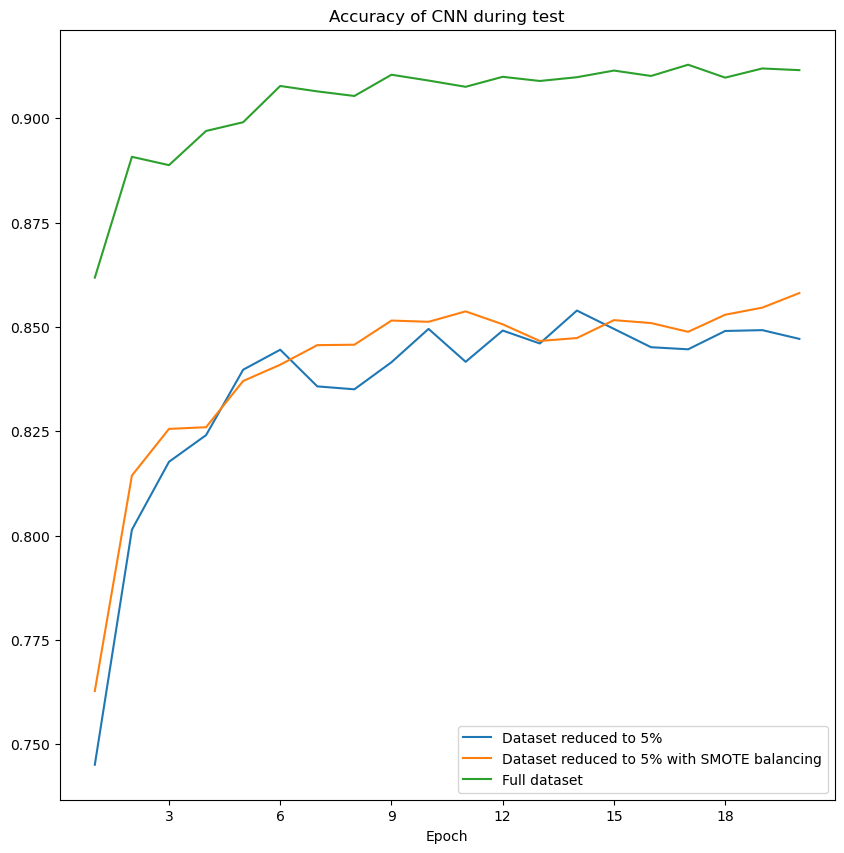

In [66]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)
fig,  ax1= plt.subplots(1, 1, figsize=(10,10))

ax1.plot(epochs[1:], accuracies_test_cnn_reduced[1:], label = "Dataset reduced to 5%")
ax1.plot(epochs[1:], accuracies_test_cnn_smote[1:], label = "Dataset reduced to 5% with SMOTE balancing")
ax1.plot(epochs[1:], accuracies_test_cnn_full[1:], label = "Full dataset")
ax1.set_title('Accuracy of CNN during test')
ax1.set_xlabel('Epoch')
ax1.legend()

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.savefig("../figures/CNN_Accuracy_comparison_smote.png")

## GAN data augmentation
In this section we will augment the data using a GAN trained on the full data set.
The motivation is the apparition of powerfull general purpose image generation services such as DALL-E, Midjourney or Stable Diffusion, the most known.
This mean in the future, we might be able to augment the data using a GAN which was not trained using a reduced dataset.

We trained the GAN on another notebook (see http://localhost:8888/lab/tree/src/FashionMNIST_GAN_Training.ipynb). It consists of 10 GANs, one for each class.

In [52]:
# Loading pretrained models
generators = [loadModel(Generator(100), f"Generator_50_class_{i:02d}")
              for i in range(n_classes)]

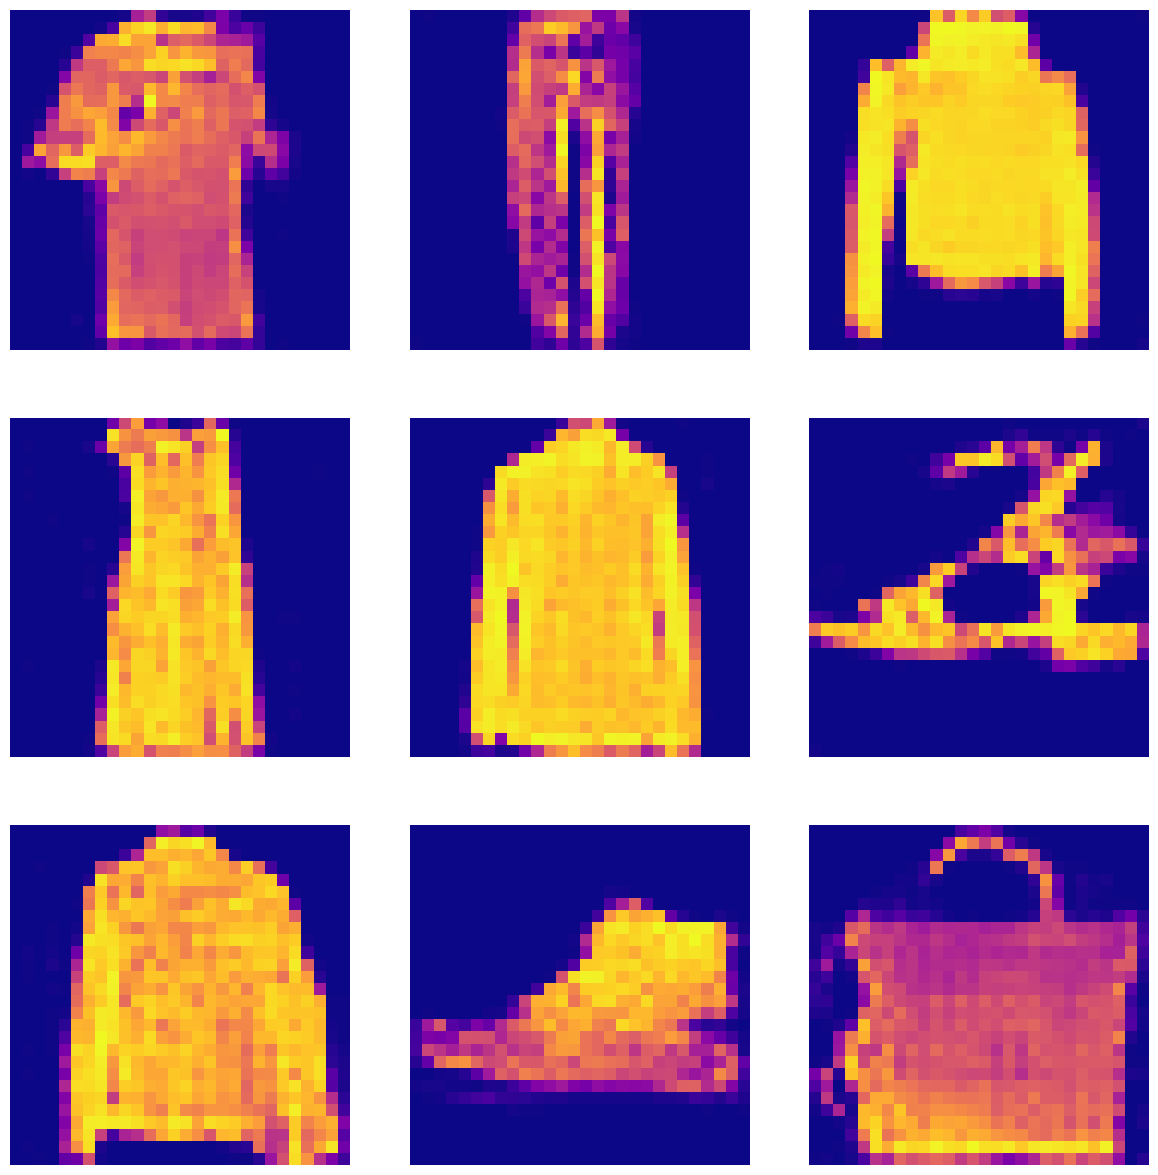

In [53]:
generated = []
for i in range(n_classes):
    noise = torch.randn(100)
    generated.append(generators[i](noise).cpu().detach())

showimgpanel(generated, 9, (3,3))